#### 아래 구현은 ratsgo님의 블로그를 참고하였음을 밝혀둡니다.

In [173]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows',50)

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV


#matplotlib을 주피터 화면 내에 띄우도록 해주는 주피터 명령어
%matplotlib inline
import pandas as pd
#matplotlib을 이용해 그래프를 그릴 수 있는 pyplot (인터페이스 역할)과, 설정을 바꾸는데 사용되는 matplotlib 둘 다 import 합니다.
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
# seaborn은 matplotlib보다 더 이쁘고 쉽게 그래프를 그릴 수 있는 라이브러리입니다. matplotlib을 이용해 동작하고, 자유도는 matplotlib에 비해 낮습니다.
import seaborn as sns

sns.set_style('whitegrid')

In [88]:
# define an empty list
noun_list = []

# open file and read the content in a list
with open('dat.txt', 'r') as filehandle:
    for line in filehandle:
        # remove linebreak which is the last character of the string
        currentPlace = line[:-1]

        # add item to the list
        noun_list.append(currentPlace)
        
documents = []
for i in range(len(noun_list)):
    documents.append(noun_list[i].split(' '))

In [89]:
from collections import Counter

'''
Counter는 리스트에 있는 요소들이 몇개씩 있는지, 개수가 많은 것부터 반환을 한다.
예를 들어 ['a','a','c','b','b']라는 리스트에 대해서는
Counter({'a':2, 'b':2, 'c':1})
을 반환한다.
'''


document_topic_counts = [Counter() for _ in documents]
'''
문서별로 K개의 토픽 분포를 보여준다.
만약 단어가 N개 있다면, 그 문서의 N개 단어 각각의 토픽 분포를 보여준다.
예를 들어 첫 번째 문서의 단어들의 분포를 보고 싶으면
document_topic_counts[0]에서
Counter({1: 4, 0: 1, 2: 0})가 나오고
첫 번째 문서는 총 5개의 단어로 구성되는데, 그 중 네 개의 단어가 첫 번째 주제에 해당된다는 뜻이다.
'''


topic_word_counts = [Counter() for _ in range(K)]
'''
토픽별로 V개의 단어 분포를 보여준다.
한 토픽에서 V개의 단어 각각의 토픽 분포를 보여준다.
topic_word_counts[0]에서
Counter({'A':3, 'B':5, 'C':2})가 나오고
0번째 토픽에서 A가 3번, B가 5번 나옴을 의미한다.
'''


topic_counts = [0 for _ in range(K)]
'''
토픽별로 할당된 총 단어수를 의미한다.
'''


document_lengths = [len(document) for document in documents]
'''
각 문서를 구성하는 단어의 총 개수.
'''


distinct_words = set(word for document in documents for word in document)
V = len(distinct_words)
'''
코퍼스에서 unique 단어 수
'''


D = len(documents)
'''
문서의 총 개수
'''

In [90]:
def p_topic_given_document(topic, d, alpha=0.1):
    '''
    - alpha는 미리 정하는 hpyer-parameter
    - document_topic_counts[d][topic]은 노테이션상 n_d,k을 의미
    - document_lengths[d]는 sum(n_d,i)을 의미
    - alpha는 n_d,k가 0일 경우 0을 곱하는 것을 방지하는 smoothing 역할
    '''
    return ((document_topic_counts[d][topic] + alpha) /
            (document_lengths[d] + K * alpha))

def p_word_given_topic(word, topic, beta=0.1):
    '''
    - beta는 미리 정하는 hyper-parameter
    - topic_word_counts[topic][word]은 노테이션상 v_k,w을 의미
    - topic_counts[topic]은 sum(v_k,j)을 의미
    - beta는 v_k,w가 0일 경우 0을 곱하는 것을 방지하는 smoothing 역할
    '''
    return ((topic_word_counts[topic][word] + beta) /
            (topic_counts[topic] + V * beta))

def topic_weight(d, word, k):
    '''
    - conditional probability
    - 정리 문서에서 (2)에 해당
    '''
    return p_word_given_topic(word, k) * p_topic_given_document(k, d)

In [91]:
def choose_new_topic(d, word):
    return sample_from([topic_weight(d, word, k) for k in range(K)])

import random
def sample_from(weights):
    '''
    - input은 weights로써, z_d,i에 대한 조건부 확률에 해당한다.
    - K개의 토픽에 대해서 계산하므로 길이는 K이다.
    - 즉, z_d,i (d번째 문서의 i번째 단어의 토픽)가 1부터 K까지의 값을 가질 확률을 담고 있는 리스트이다.
    - 예를 들어 [0.2,0.3,0.5]라면 z_d,i는 세 번째 토픽에 배정될 확률이 0.5로 가장 크다.
    '''
    # i를 weights[i] / sum(weights)
    # 확률로 반환
    total = sum(weights)
    # 0과 total 사이를 균일하게 선택
    rnd = total * random.random()
    # 아래 식을 만족하는 가장 작은 i를 반환
    # weights[0] + ... + weights[i] >= rnd
    for i, w in enumerate(weights):
        rnd -= w
        if rnd <= 0:
            return i

In [92]:
random.seed(0)

# topic 수 지정
K=3

# 처음 iteration 시작 이전에 각 단어의 토픽을 random assignment
document_topics = [[random.randrange(K) for word in document] 
                   # 한 문서안에 있는 단어의 수 만큼 0 ~ K-1의 정수를 random generate
                   # 즉, 각 단어의 토픽을 임의로 배정하겠다는 의미.
                    for document in documents]

# 위와 같이 랜덤 초기화한 상태에서 
# AB를 구하는 데 필요한 숫자를 세어봄
for d in range(D):
    for word, topic in zip(documents[d], document_topics[d]):
        document_topic_counts[d][topic] += 1
        topic_word_counts[topic][word] += 1
        topic_counts[topic] += 1

In [155]:
document_topics[0]

[0, 1, 1, 1, 1]

In [94]:
for iter in range(10000):
    for d in range(D):
        for i, (word, topic) in enumerate(zip(documents[d],
                                              document_topics[d])):
            # 깁스 샘플링 수행을 위해
            # 샘플링 대상 word와 topic을 제외하고 세어봄
            document_topic_counts[d][topic] -= 1
            topic_word_counts[topic][word] -= 1
            topic_counts[topic] -= 1
            document_lengths[d] -= 1

            # 깁스 샘플링 대상 word와 topic을 제외한 
            # 말뭉치 모든 word의 topic 정보를 토대로
            # 샘플링 대상 word의 새로운 topic을 선택
            new_topic = choose_new_topic(d, word)
            document_topics[d][i] = new_topic

            # 샘플링 대상 word의 새로운 topic을 반영해 
            # 말뭉치 정보 업데이트
            document_topic_counts[d][new_topic] += 1
            topic_word_counts[new_topic][word] += 1
            topic_counts[new_topic] += 1
            document_lengths[d] += 1

In [95]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words="english", max_features=1000)
transformed = cv.fit_transform(noun_list)

In [96]:
# Define Search Param
search_params = {'n_components': [3, 5, 7], 'learning_decay': [.5, .7, .9],'random_state' : [43]}

# Basic Model
lda = LatentDirichletAllocation()

# Initialize Grid Search
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(transformed)

C:\Users\sbh0613\anaconda\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                   

In [97]:
# Best Model
best_lda_model = model.best_estimator_

# Create Document - Topic Matrix
lda_output = best_lda_model.transform(transformed)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(lda_output))]

# Make the pandas dataframe
df_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
df_topic['dominant_topic'] = np.argmax(df_topic.values, axis=1)

df_topic.head()

,Topic0,Topic1,Topic2,dominant_topic
Doc0,0.08,0.07,0.85,2
Doc1,0.12,0.11,0.77,2
Doc2,0.05,0.05,0.89,2
Doc3,0.04,0.04,0.92,2
Doc4,0.31,0.65,0.04,1


In [170]:
document_topic_counts[4]

Counter({2: 9, 0: 0, 1: 0})

In [100]:
for topic_idx, topic in enumerate(best_lda_model.components_):
    label = '{}: '.format(topic_idx)
    print(label, " ".join([cv.get_feature_names()[i]
                           for i in topic.argsort()[:-15:-1]]))

0:  토트넘 손흥민 케인 부상 알리 첼시 언론 복귀 아시안컵 시즌 이과인 한국 임대 위기
1:  손흥민 레알 모라 마드리드 선수 축구 득점 구단 첼시 최고 위해 경기 감독 앙리
2:  맨유 첼시 결승 토트넘 맨시티 리그컵 손흥민 아스널 티노 포체 솔샤르 리버풀 좌절 바오


In [188]:
topic_0_list = []

for tup in topic_word_counts[0].most_common()[:10]:
    topic_0_list.append(tup[0])
           
topic_0_df = pd.DataFrame({'word' : topic_0_list, 'most' : [i for i in reversed(range(1,11))]})


topic_1_list = []

for tup in topic_word_counts[1].most_common()[:10]:
    topic_1_list.append(tup[0])
           
topic_1_df = pd.DataFrame({'word' : topic_1_list, 'most' : [i for i in reversed(range(1,11))]})


topic_2_list = []

for tup in topic_word_counts[2].most_common()[:10]:
    topic_2_list.append(tup[0])
           
topic_2_df = pd.DataFrame({'word' : topic_2_list, 'most' : [i for i in reversed(range(1,11))]})


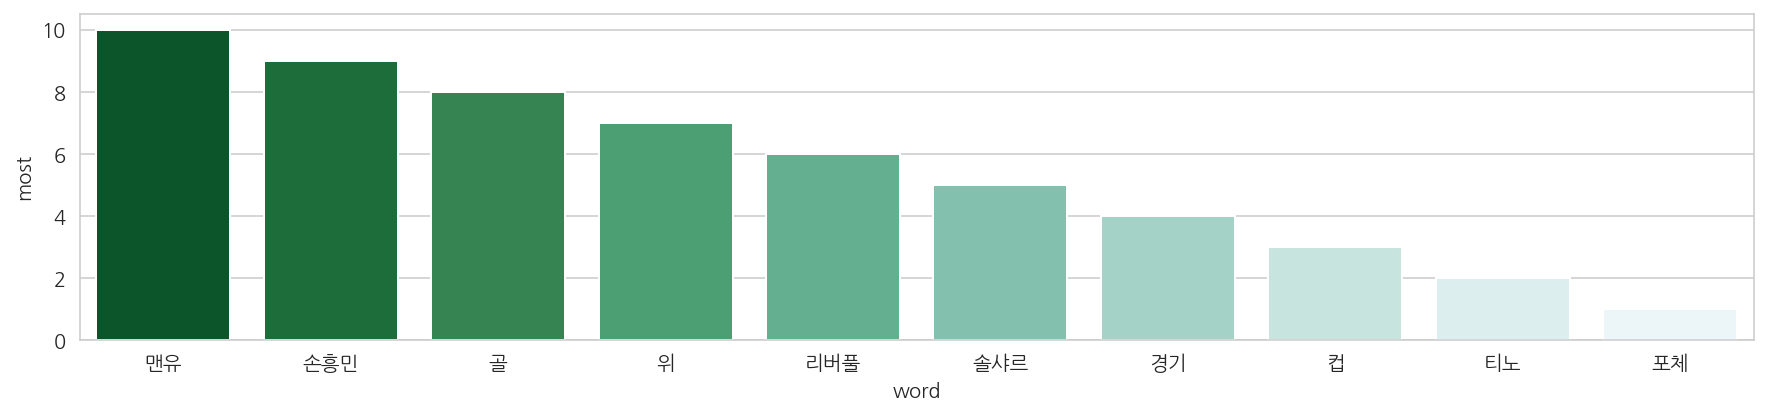

In [211]:
mpl.rc('font', family = 'NanumGothic')
%matplotlib inline

# retina 옵션을 통해 해상도를 올립니다.
from IPython.display import set_matplotlib_formats

set_matplotlib_formats('retina')

#또는  %config InlineBackend.figure_format = 'retina' 사용 가능

plt.figure(figsize=[15,3])
sns.barplot(x='word', y='most',ci=99, data=topic_0_df, palette=sns.color_palette("BuGn_r", 10))

plt.savefig('./.ipynb_checkpoints/그림/gibbs_0.png')

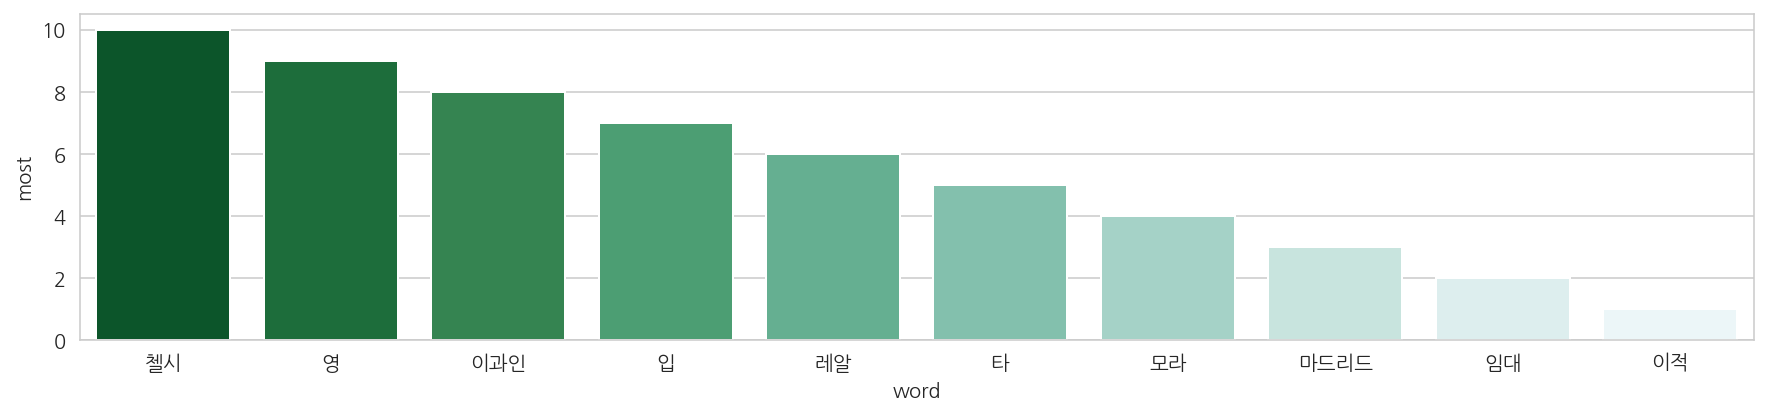

In [212]:
plt.figure(figsize=[15,3])
sns.barplot(x='word', y='most',ci=99, data=topic_1_df, palette=sns.color_palette("BuGn_r", 10))

plt.savefig('./.ipynb_checkpoints/그림/gibbs_1.png')

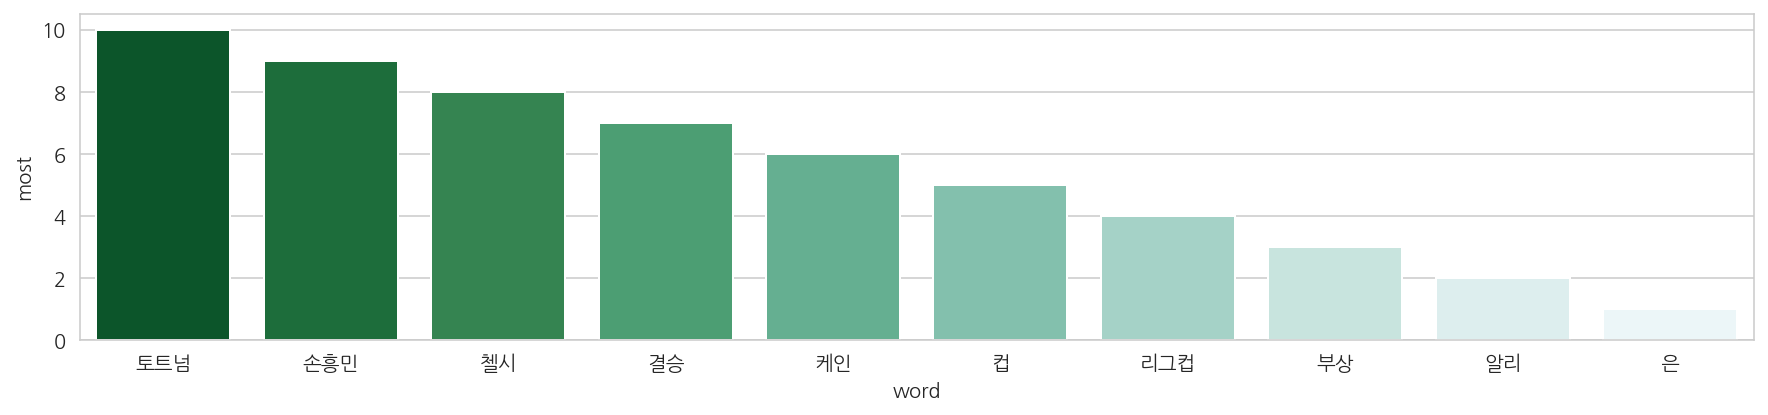

In [213]:
plt.figure(figsize=[15,3])
sns.barplot(x='word', y='most',ci=99, data=topic_2_df, palette=sns.color_palette("BuGn_r", 10))

plt.savefig('./.ipynb_checkpoints/그림/gibbs_2.png')

In [204]:
lda_0 = '토트넘 손흥민 케인 부상 알리 첼시 언론 복귀 아시안컵 시즌'.split(' ')
lda_1 = '손흥민 레알 모라 마드리드 선수 축구 득점 구단 첼시 최고'.split(' ')
lda_2 = '맨유 첼시 결승 토트넘 맨시티 리그컵 손흥민 아스널 티노 포체'.split(' ')

lda_0_df = pd.DataFrame({'word' : lda_0, 'most' : [i for i in reversed(range(1,11))]})
lda_1_df = pd.DataFrame({'word' : lda_1, 'most' : [i for i in reversed(range(1,11))]})
lda_2_df = pd.DataFrame({'word' : lda_2, 'most' : [i for i in reversed(range(1,11))]})

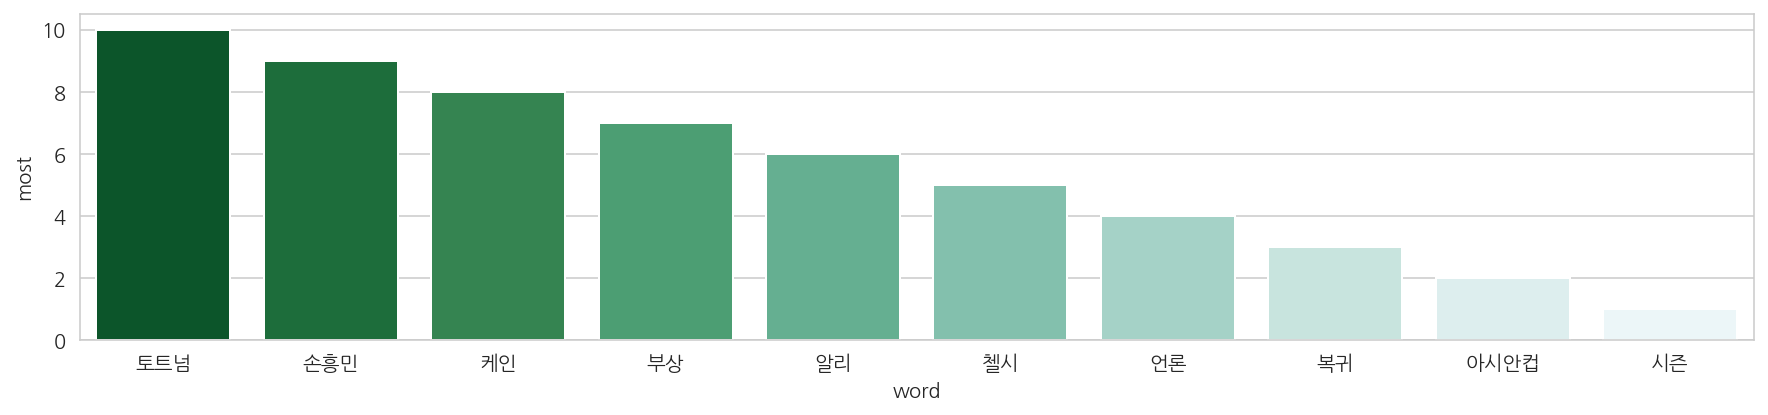

In [214]:
plt.figure(figsize=[15,3])
sns.barplot(x='word', y='most',ci=99, data=lda_0_df, palette=sns.color_palette("BuGn_r", 10))

plt.savefig('./.ipynb_checkpoints/그림/lda_0.png')

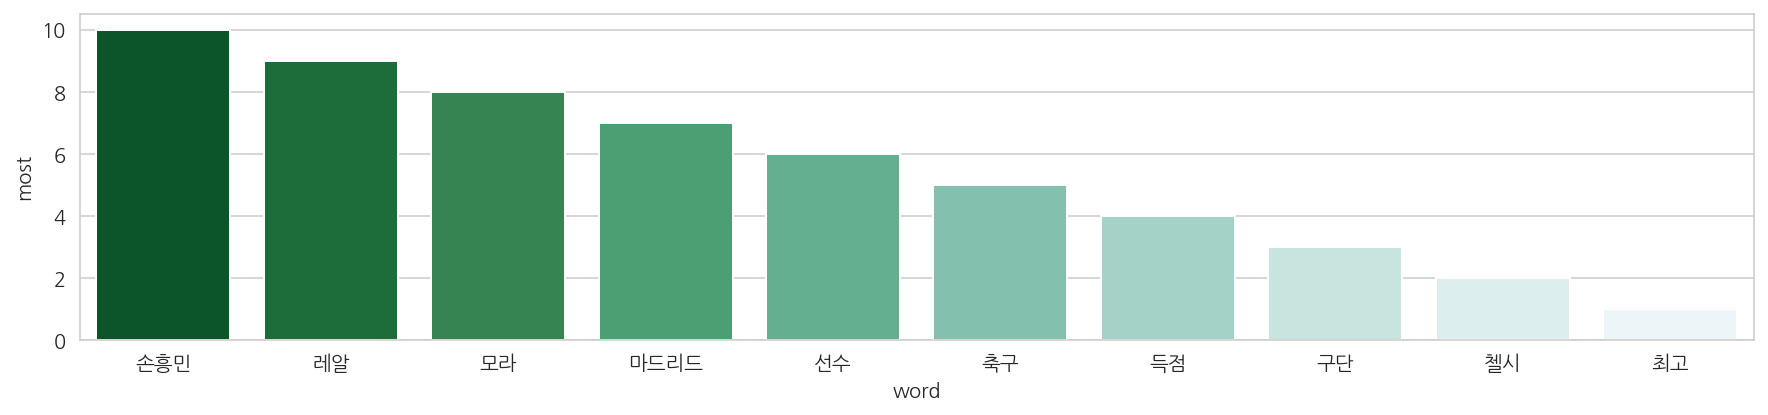

In [219]:
plt.figure(figsize=[15,3])
sns.barplot(x='word', y='most',ci=99, data=lda_1_df, palette=sns.color_palette("BuGn_r", 10))

plt.savefig('./.ipynb_checkpoints/그림/lda_1.png')

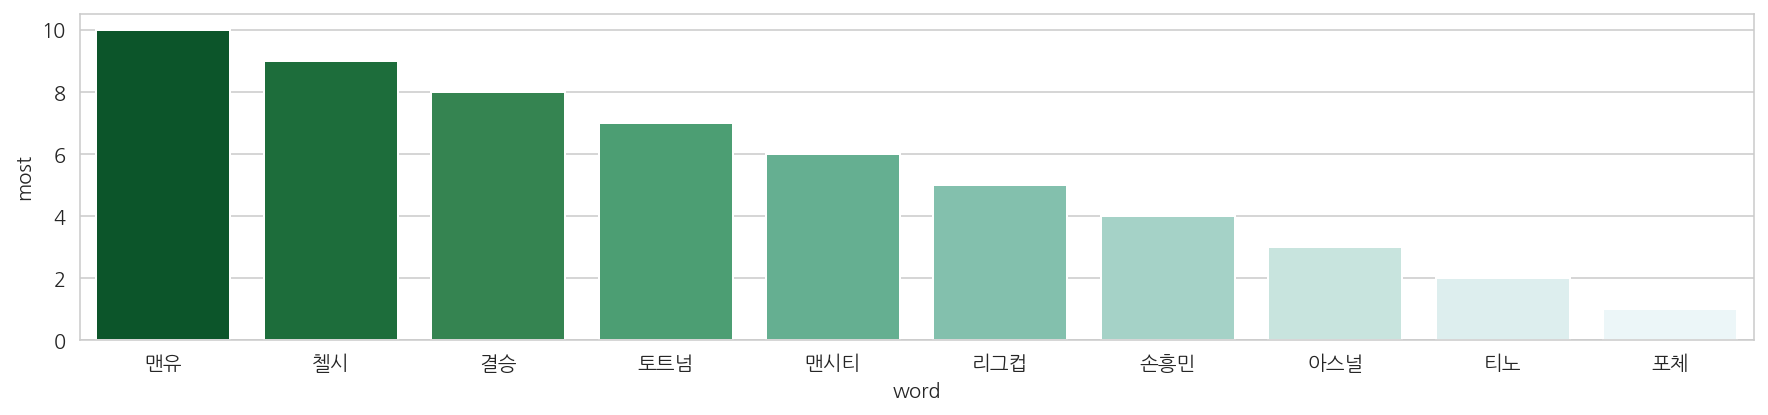

In [220]:
plt.figure(figsize=[15,3])
sns.barplot(x='word', y='most',ci=99, data=lda_2_df, palette=sns.color_palette("BuGn_r", 10))

plt.savefig('./.ipynb_checkpoints/그림/lda_2.png')